In [1]:
using Pkg
Pkg.activate(".")
using DifferentialEquations, Plots, ReferenceFrameRotations, WriteVTK, Distances # , FiniteDiff, ForwardDiff

  Activating project at `c:\Users\Liam\Documents\PhD\Research\Scripts\StochasticSimulations`


In [1]:
# This code is for simulating a whole virus
# This is to emulate a receptor where the points represent
# the hinges.
# Each hinge can have a defined potential in the local
# spherical coordinates, which is converted to global 
# Cartesian via rotation quaternions and directional cosine
# matrices.
# The simulation is carried out in the global Cartesian
# coordinate system.

# Define some basic coordinate identities
function CartesianToSpherical(X::Vector)
    r = sqrt(X[1]^2 + X[2]^2 + X[3]^2)
    θ = angle(X[1] + im*X[2])
    ϕ = acos(X[3]/r)
    return [r,θ,ϕ]
end

function SphericalToCartesian(Φ::Vector)
    x = Φ[1]*cos(Φ[2])*sin(Φ[3])
    y = Φ[1]*sin(Φ[2])*sin(Φ[3])
    z = Φ[1]*cos(Φ[3])
    return [x,y,z]
end

function StCθ(Φ::Vector)
    x = - Φ[1]*sin(Φ[2])*sin(Φ[3])
    y = Φ[1]*cos(Φ[2])*sin(Φ[3])
    z = 0
    return [x,y,z]
end

function StCϕ(Φ::Vector)
    x = Φ[1]*cos(Φ[2])*cos(Φ[3])
    y = Φ[1]*sin(Φ[2])*cos(Φ[3])
    z = - Φ[1]*sin(Φ[3])
    return [x,y,z]
end

function StCr(Φ::Vector)
    x = cos(Φ[2])*sin(Φ[3])
    y = sin(Φ[2])*sin(Φ[3])
    z = cos(Φ[3])
    return [x,y,z]
end

Jac(Φ) = [StCr(Φ) StCθ(Φ) StCϕ(Φ)]

# Find the directional cosine matrix (DCM) for a given set of angles and
# a set of initial basis vectors.
function FindDCM(θ,ϕ,K::Matrix{Float64})
    I3 = 1.0*Matrix(I,3,3)
    qϕ = Quaternion(cos(ϕ/2), sin(ϕ/2)*K[2,:]) # Rotate by ϕₙ' around ŷ(n-1)
    qθ = Quaternion(cos(θ/2), sin(θ/2)*K[3,:]) # Rotate by θₙ' around ẑ(n-1)
    q = qθ*qϕ

    for n in 1:3
        K[n,:] = vect(q*K[n,:]/q)
    end
    
    return [I3[n,:]' * K[m,:] for n in 1:3, m in 1:3], K, [qθ,qϕ]
end

# Algorithm to convert Cartesian coordinates of hinge points and find 
# their local spherical coordinates.
function FindRecLocals(X::Matrix)
    Locals = reshape(CartesianToSpherical(X[1,:]),1,3)
    # D, K, q = FindDCM(Locals[1,2], Locals[1,3], 1.0*Matrix(I,3,3))
    D = 1.0*Matrix(I,3,3)
    KList = [1.0*Matrix(I,3,3)]
    Q = reshape([],2,0)
    
    for n in 2:size(X)[1]
        Locals = [Locals; CartesianToSpherical(D' * (X[n,:] - X[n-1,:]))']
        D, K, q = FindDCM(Locals[n,2], Locals[n,3], copy(KList[end]))
        push!(KList, copy(K))
        Q = hcat(Q, q)
    end
    
    return Locals, KList, Q
end

function FindLocals(X::Matrix{Float64}, N::Integer, NR::Integer)
    ξ = [[X[1,:]'; X[1+N*(nr-1)+1:1+N*nr,:]] for nr in 1:NR]
    Locals = Array{Float64}(undef,0,3)
    QList = []
    KKList = []

    for x in ξ
        TL, KList, QArray = FindRecLocals(x)
        push!(QList,QArray)
        push!(KKList,KList)
        Locals = vcat(Locals,TL)
    end

    return vcat(Locals[1,:]', Locals[(1:end).%(N+1) .!= 1, :]), KKList, QList
end

function FindRecCartesians(Φ::Matrix)
    D, K = 1.0*Matrix(I,3,3), 1.0*Matrix(I,3,3) # FindDCM(Φ[1,2], Φ[1,3], 1.0*Matrix(I,3,3))
    DCMs = [copy(D)]
    Carts = reshape(SphericalToCartesian(Φ[1,:]),1,3)

    for n in 2:size(Φ,1)
        D, K = FindDCM(Φ[n,2], Φ[n,3], K)
        Carts = [Carts; reshape(Carts[n-1,:] + DCMs[n-1]*SphericalToCartesian(Φ[n,:]),1,3)]
        push!(DCMs, copy(D))
    end

    return Carts
end

function FindCartesians(Φ::Matrix,N::Integer)
    NR = trunc(Int, (size(Φ,1)-1)/N)
    P = [[Φ[1,:]';Φ[1+N*(nr-1)+1:1+N*nr,:]] for nr in 1:NR]
    Carts = Array{Float64}(undef,0,3)

    for ϕ in P
        Carts = vcat(Carts,FindRecCartesians(ϕ))
    end

    return vcat(copy(Carts[1,:]'), Carts[(1:end).%(N+1) .!= 1, :])
end

# Jacobian of a single receptor
function JacobianMinor(U,N)
    Temp = FiniteDiff.finite_difference_jacobian(FindRecCartesians, U)
    J = zeros(size(Temp))
    for n in 1:N
        J[3*n-2,:] = Temp[n,:]
        J[3*n-1,:] = Temp[N+n,:]
        J[3*n,:] = Temp[2*N+n,:]
    end
    Temp = copy(J)
    for n in 1:N
        J[:,3*n-2] = Temp[:,n]
        J[:,3*n-1] = Temp[:,N+n]
        J[:,3*n] = Temp[:,2*N+n]
    end
    return J
end

function ModularJacobian(U,N,Nr)
    # Jacobian = zeros(3*N*Nr+3, 3*N*Nr+3)
    JList = []
    for nr in 1:Nr
        Jm = JacobianMinor(vcat(copy(U[1,:]'),U[1+N*(nr-1)+1:1+N*nr,:]),N+1)
        push!(JList, Jm)
        # Jacobian[3+3*N*(nr-1)+1:3+3*N*nr,1:3] = Jm[4:end,1:3]
        # Jacobian[3+3*N*(nr-1)+1:3+3*N*nr,3+3*N*(nr-1)+1:3+3*N*nr] = Jm[4:end,4:end]
    end
    # Jacobian[1:3,1:3] = [StCr(U[1,:]) StCθ(U[1,:]) StCϕ(U[1,:])]

    return JList # , Jacobian
end

# Calculate the Jacobian of dΦ = J*dX
# function Jacobian(U::Matrix{Float64},N::Integer,Nr::Integer)
#     Temp = FiniteDiff.finite_difference_jacobian(x -> FindCartesians(x,N), U)
#     J = zeros(size(Temp))
#     J[1,:] = copy(Temp[1,:])
#     J[2,:] = copy(Temp[1+N*Nr+1,:])
#     J[3,:] = copy(Temp[2*(1+N*Nr)+1,:])
#     for nr in 1:Nr
#         for n in 1:N
#             J[3+3*N*(nr-1)+3*n-2,:] = Temp[N*(nr-1)+1+n,:]        # x of receptor nr, particle n
#             J[3+3*N*(nr-1)+3*n-1,:] = Temp[(1+N*Nr)+N*(nr-1)+1+n,:]  # y of receptor nr, particle n
#             J[3+3*N*(nr-1)+3*n,:] = Temp[2*(1+N*Nr)+N*(nr-1)+1+n,:]         # z of receptor nr, particle n
#         end
#     end
#     Temp = copy(J)
#     J[:,1] = copy(Temp[:,1])
#     J[:,2] = copy(Temp[:,1+N*Nr+1])
#     J[:,3] = copy(Temp[:,2*(1+N*Nr)+1])
#     for nr in 1:Nr
#         for n in 1:N
#             J[:,3+3*N*(nr-1)+3*n-2] = Temp[:,N*(nr-1)+1+n]        # x of receptor nr, particle n
#             J[:,3+3*N*(nr-1)+3*n-1] = Temp[:,(1+N*Nr)+N*(nr-1)+1+n]  # y of receptor nr, particle n
#             J[:,3+3*N*(nr-1)+3*n] = Temp[:,2*(1+N*Nr)+N*(nr-1)+1+n]         # z of receptor nr, particle n
#         end
#     end
#     return J
# end

ModularJacobian (generic function with 1 method)

In [4]:
# This is the analytical Jacobian. It is only valid for N < 3 since higher orders are currently incorrect.
# Need to look again at the analytical Jacobian for N > 2.
function AJ(Φ,K,q,N)
    # Initialise sub-Jacobians
    Jacobian = zeros(3*N,3*N)
    # append!([1.0*Matrix(I,3,3)], K) # The identity matrix is the 0th frame, but 1st in this list
    # append!([1.0*Quaternion(1,0,0,0)], Q) # The identity quaternion is of the 0th frame, but 1st in this list
    Q = [q[1,n]*q[2,n] for n in 1:size(q,2)]

    # Each K has form [x';y';z'], so need to take transpose to get form of [x y z]
    K = [copy(K[l]') for l in 1:length(K)]

    # dUnits are organised in the list as:
    # 1: dx/dθ, 2: dy/dθ, 3: dz/dθ
    # 4: dx/dϕ, 5: dy/dϕ, 6: dz/dϕ
    
    for m in 1:N-1
        # Construct the first entry of the unit vector matrix column, i.e. calculate diagonals
        dUnits = [ zeros(3,m) for l in 1:6 ]
        for l in 1:3
            # θ derivatives
            TempUnit = (Quaternion(K[m][:,3]) * Quaternion(K[m+1][:,l]) - Quaternion(K[m+1][:,l]) * Quaternion(K[m][:,3])) / 2
            dUnits[l] = hcat(dUnits[l], vect(TempUnit))
            
            # ϕ derivatives
            TempUnit = (Q[m] * (Quaternion(K[m][:,2]) * Quaternion(K[m][:,l]) - Quaternion(K[m][:,l]) * Quaternion(K[m][:,2])) / Q[m]) / 2
            dUnits[l+3] = hcat(dUnits[l+3], vect(TempUnit))
        end

        # Fill out the rest of column below the first entry (all 0's above)
        if m < N-2
            println("N must be less than 3")
            throw()
        end

        # Now fill out the Jacobian column
        for n in m:N-1              
            if m+1>n
                Jacobian[3*n+1:3*n+3, 3*m+1:3*m+3] = K[m]*Jac(Φ[m+1,:])
            else
                Jacobian[3*n+1:3*n+3, 3*m+1] = K[m]*StCr(Φ[m+1,:])
                
                FirstTerm = sum( [copy([dUnits[1][:,k] dUnits[2][:,k] dUnits[3][:,k]])*SphericalToCartesian(Φ[k+1,:]) for k in m+1:n] )
                SecondTerm = K[m]*StCθ(Φ[m+1,:])
                Jacobian[3*n+1:3*n+3, 3*m+2] = FirstTerm + SecondTerm
                
                FirstTerm = sum( [copy([dUnits[4][:,k] dUnits[5][:,k] dUnits[6][:,k]])*SphericalToCartesian(Φ[k+1,:]) for k in m+1:n] )
                SecondTerm = K[m]*StCϕ(Φ[m+1,:])
                Jacobian[3*n+1:3*n+3, 3*m+3] = FirstTerm + SecondTerm
            end
        end
    end

    for n in 1:N
        Jacobian[3*n-2:3*n, 1:3] = Jac(Φ[1,:])
    end

    return Jacobian
end

function AllTheAJ(Φ::Matrix,KKList,QList,N,NR)
    J = zeros(3+3*N*NR,3+3*N*NR)
    for nr in 1:NR
        ϕ = [Φ[1,:]'; Φ[1+N*(nr-1)+1:1+N*nr,:]]
        AnJ = AJ(ϕ,KKList[nr],QList[nr],N+1)
        J[3+3*N*(nr-1)+1:3+3*N*nr,1:3] = AnJ[4:end,1:3]
        J[3+3*N*(nr-1)+1:3+3*N*nr,3+3*N*(nr-1)+1:3+3*N*nr] = AnJ[4:end,4:end]
    end
    J[1:3,1:3] = Jac(Φ[1,:])
    return J
end

AllTheAJ (generic function with 1 method)

In [20]:
k = 10
κ = 1000
D = 0.1
R = 1
N = 2     # Number of joints on receptor
NRec = 10  # Number of receptors
ϵ = 0.77
σ = 0.05

t0 = 0.0
tf = 0.1
dt = 1//1000
u0 = [0., 10*eps(), 0.] # [0,0,eps(),0,0,1,0,0,2,0,0,-1,0,0,-2]
append!(u0,rand(3*(1+N*NRec)-3) .- 0.5)

function ReceptorV(u,N)
    # Insert localised forces here
    # Function of (r,θ,ϕ)ₙ' for all n ∈ [1,N]
    du = zeros(length(u))

    # The second 3 represent the base of the receptor
    du[1] = -κ*(u[1] - R) - κ*(u[4] - 0.31*R)
    du[2] = 0
    du[3] = 0

    for n in 4:3:3*N-3
        du[n] = -κ*(u[n]-R) - κ*(u[n+3]-R)
        du[n+1] = 0
        du[n+2] = -k*u[n+2]
    end

    du[end-2] = -κ*(u[end-2] - 0.31*R)
    du[end-1] = 0
    du[end] = -k*(u[end])

    return du
end

function VirusV(u,NR)
    dϕ = zeros(length(u)) # *NR - (NR-1))

    # These first 3 represent the centre of the virus
    dϕ[1] = 0 # -κ*(u[4] - R)  # r₀'
    dϕ[2] = 0              # θ₀'
    dϕ[3] = 0              # ϕ₀'

    # The receptors
    for nr in 1:NR
        RBlock = 3*N*(nr-1)
        dϕ[3+RBlock+1:3+RBlock+3*N] = ReceptorV(u[3+RBlock+1:3+RBlock+3*N],N)
    end
    return dϕ
end

function det(du,u,p,t)
    Φ, KKList, QList = FindLocals(copy(reshape(u,3,1+N*NRec)'),N,NRec)
    Φ_vect = reshape(copy(Φ'),length(Φ))
    du[1:end] = VirusV(Φ_vect, NRec)   # Define potential' (force) in terms of local spherical
    if N < 3
        # Convert forces to Cartesian coordinates
        du[1:end] = AllTheAJ(Φ,KKList,QList,N,NRec) * du[1:end]
        # Φ, KKList, QList = nothing

        # Implement Pauli repulsion of base particles
        Mat = reshape(u[1:end], 3, 1+N*NRec)
        dMat = reshape(du[1:end], 3, 1+N*NRec)
        BasePositions = [Mat[:, 2+N*n] for n in 0:NRec-1]
        BaseDists = pairwise(Euclidean(), [Mat[n, 2+N*nr] for n in 1:3, nr in 0:NRec-1])
        for m in 1:NRec
            BasePositionsTemp = BasePositions[10*eps() .< BaseDists[:,m] .<= 100*σ]
            DistVec = BaseDists[:,m][10*eps() .< BaseDists[:,m] .<= 3*σ]
            if !isempty(DistVec)
                dMat[1:3,2+N*(m-1)] += 48*ϵ*σ^12 * sum( [DistVec[n]^(-14) * (BasePositionsTemp[n] - BasePositions[m]) for n in 1:length(DistVec)] )
            end
        end

        
        du[1:end] = reshape(dMat,1,3+3*N*NRec)
    else
        JList = ModularJacobian(Φ,N,NRec)
        for nr in 1:NRec
            V[3+3*N*(nr-1)+1:3+3*N*nr] = JList[nr][4:end,1:end]*[V[1:3]; V[3+3*N*(nr-1)+1:3+3*N*nr]]
        end
    end

    if mod(trunc(t/dt),trunc(tf/dt/100)) == 0
        # display(trunc(1000*t))
        print(String("$(trunc(Int,t/tf*100))% \r"))
        flush(stdout)
    end

    # if t == 0
    #     # display(trunc(1000*t))
    #     println(sizeof(Φ),", ",sizeof(KKList),", ",sizeof(QList))
    #     flush(stdout)
    # end
end

function stoch(du,u,p,t)
    du[1:3] .= 0
    # du[4:6] .= sqrt(6*D)
    du[4:end] .= sqrt(2*D)
end

TimeRange = range(t0,tf,step = dt)[1:end-1]
prob = SDEProblem(det,stoch,u0,(t0,tf))
println("Problem defined")
sol = solve(prob, EM(), dt=dt, saveat=(tf-t0)/100)
print("100% \n")
println("Problem solved")

Problem defined
100% 
Problem solved


┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase C:\Users\Liam\.julia\packages\SciMLBase\QqtZA\src\retcodes.jl:355


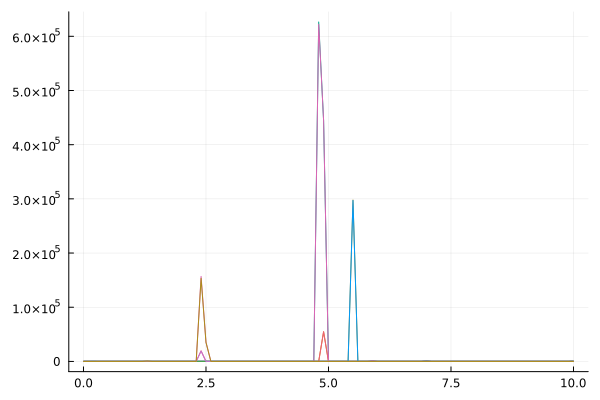

In [55]:
SN = []

# Loop through all of the particles and arrange their xyz coordinates in 3-wide column
for i in 1:1+N*NRec
    push!(SN, [sol.u[n][m] for n in 1:length(sol), m in 1+3*(i-1):3+3*(i-1)])
end

# Calculate the distance from the virus origin at each time step
DISTS = []
SR = []
for np in 1:1+N*NRec
    for n in 1:size(SN[np],1)
        push!(DISTS, euclidean(SN[1][n,:], SN[np][n,:]))
    end
    push!(SR, DISTS)
    DISTS = []
end

P = plot(legend=:none)
for n in 1:1+N*NRec
    plot!(sol.t,SR[n])
end
display(P)

# plotly()
# P = plot(SN[1][:,1], SN[1][:,2], SN[1][:,3],
#     legend = :none,
#     xlabel="x",
#     ylabel="y",
#     zlabel="z")

# for n in 2:1+N*NRec
#     plot!(SN[n][:,1], SN[n][:,2], SN[n][:,3])
# end
# display(P)

In [174]:
let
    # Create lists of lines and polygons connecting different points in space
    for t in 1:25:length(sol.t)
        points = [SN[n][t,m] for m in 1:3, n in 1:1+N*NRec] # (x, y, z) locations
        lines = [MeshCell(PolyData.Lines(), (1, i)) for i in 2:2:N*NRec]
        append!(lines, [MeshCell(PolyData.Lines(), (i, i+1)) for i in 2:2:N*NRec])
        # polys = [MeshCell(PolyData.Polys(), i:(i + 6)) for i = 1:3:20]
        vtk = vtk_grid("vtpfiles/my_vtp_file_$t", points, lines) #, polys)
        outfiles = vtk_save(vtk)
    end
end